In [1]:
import pandas as pd 
import numpy as np

import os 
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
# My module built with Spotify API and spotipy library
from spotify import Spotify

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt 
import seaborn as sns

# My own credenctials
from utils.config import SpotifyCredectials

### Intialize Spotify API with artist Seaching Query

In [2]:
cred = SpotifyCredectials()

my_id = cred.my_id
my_secret = cred.my_secret

spotify = Spotify('Oasis', my_id, my_secret)

### Get data

In [3]:
# Get top 100 of Oasis audio feature data

n_top_tracks = 100

filtered_top_tracks_df = spotify.filter_by_popularity(n_top_tracks = n_top_tracks)
filtered_top_tracks_df.columns

Index(['name', 'danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'duration_ms', 'time_signature'],
      dtype='object')

### Apply PCA(Principle Component Analysis)

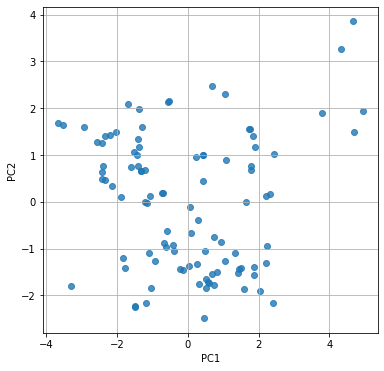

In [4]:
scaled_df_for_pca = spotify.standard_scaling(filtered_top_tracks_df[filtered_top_tracks_df.columns[1:]])

n_components = 2

pca = PCA(n_components=n_components)
pca.fit(scaled_df_for_pca)
feature = pca.transform(scaled_df_for_pca)
pca_df = pd.DataFrame(feature, columns=["PC{}".format(x + 1) for x in range(n_components)])


plt.figure(figsize=(6, 6))
plt.scatter(feature[:, 0], feature[:, 1], alpha=0.8)
plt.grid()
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

In [5]:
pd.DataFrame(pca.components_, columns=filtered_top_tracks_df.columns[1:], index=["PC{}".format(x + 1) for x in range(n_components)])

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
PC1,0.432312,-0.395074,-0.06397,-0.144969,0.139835,-0.455339,0.315903,-0.320275,-0.325107,0.276032,-0.083347,-0.110098,-0.041225
PC2,-0.150726,-0.358505,-0.15227,-0.584047,-0.039534,-0.056262,0.219475,0.354276,0.439095,-0.099379,-0.297198,0.054165,-0.110040


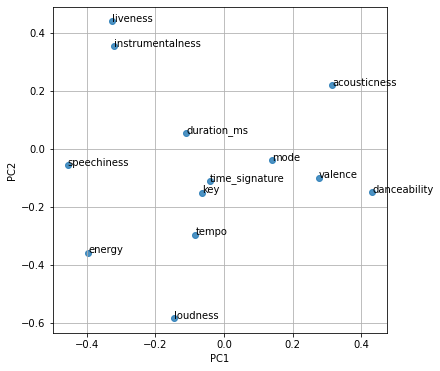

In [6]:
plt.figure(figsize=(6, 6))
for x, y, name in zip(pca.components_[0], pca.components_[1], filtered_top_tracks_df.columns[1:]):
    plt.text(x, y, name)
plt.scatter(pca.components_[0], pca.components_[1], alpha=0.8)
plt.grid()
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

### Apply KMeans clustering model

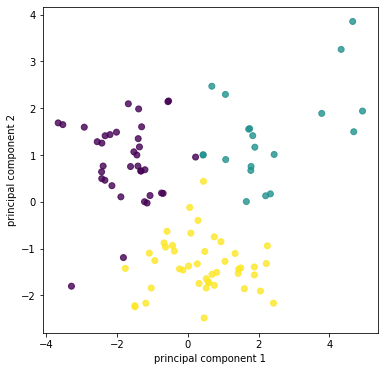

In [7]:
model = KMeans(n_clusters=3, random_state=1)
model.fit(pca_df)
cluster = model.labels_
pca_df['cluster'] = cluster


plt.figure(figsize=(6, 6))
plt.scatter(feature[:, 0], feature[:, 1], alpha=0.8, c=cluster)
plt.xlabel('principal component 1')
plt.ylabel('principal component 2')
plt.show()